In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
np.set_printoptions(suppress=True)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 

__data__ - first_set.xlsx, second_set.xlsx, third_set.xlsx merged. 

Three columns transformed to __(text, target)__ pairs, where __text__ - values of name, surname, patronymic and __target__ - corresponding label ('Ім’я' 'По батькові' 'Прізвище')

In [2]:
data = pd.read_csv('data/preprocessed.csv')
test = pd.read_csv('data/dev_data(dirty).csv')
data.dropna(inplace=True)

print(f'Data shape: {data.shape} \t Test shape: {test.shape} \n')
data.head()

Data shape: (358172, 2) 	 Test shape: (434664, 2) 



,text,target
0,Король,Прізвище
1,Король,Прізвище
2,Пащенко,Прізвище
3,Щоголева,Прізвище
4,Солоха,Прізвище


In [3]:
test['target'].value_counts()

Прізвище       144888
Ім’я           144888
По батькові    144888
Name: target, dtype: int64

In [4]:
data['target'].value_counts()

Прізвище       119417
Ім’я           119415
По батькові    119340
Name: target, dtype: int64

In [5]:
#test = test.drop_duplicates()
#data = data.drop_duplicates()
print(f'Data shape: {data.shape} \t Test shape: {test.shape} \n')

Data shape: (358172, 2) 	 Test shape: (434664, 2) 



In [6]:
test['target'].value_counts()

Прізвище       144888
Ім’я           144888
По батькові    144888
Name: target, dtype: int64

In [7]:
# train-test split for validation
X_train, X_val, y_train, y_val = train_test_split(data['text'], data['target'], stratify=data['target'], random_state=42, train_size=0.9)
print(f'Train shape: {X_train.shape} \t Val shape: {X_val.shape} \n')

Trian shape: (322354,) 	 Val shape: (35818,) 



# CountVectorizer

In [8]:
vectorizer_example = CountVectorizer(lowercase=True, ngram_range=(1, 2), analyzer='char')
example = ['Анатоліївна', 'Петрівна']
example_vectors = vectorizer_example.fit_transform(example).toarray()

In [9]:
example_df = pd.DataFrame(example_vectors, columns=vectorizer_example.get_feature_names())
example_df.insert(0, 'Text', example)
example_df.head()

,Text,а,ан,ат,в,вн,е,ет,л,лі,н,на,о,ол,п,пе,р,рі,т,то,тр,і,ів,ії,ї,їв
0,Анатоліївна,3,1,1,1,1,0,0,1,1,2,2,1,1,0,0,0,0,1,1,0,1,0,1,1,1
1,Петрівна,1,0,0,1,1,1,1,0,0,1,1,0,0,1,1,1,1,1,0,1,1,1,0,0,0


In [10]:
%%time
# text vectorization
vectorizer = CountVectorizer(
    encoding='utf-8', 
    lowercase=True, 
    ngram_range=(1, 3), 
    analyzer='char', 
    min_df=2, 
    max_features=120000
)
X_train_vect = vectorizer.fit_transform(X_train)
X_val_vect = vectorizer.transform(X_val)
X_test_vect = vectorizer.transform(test['text'].fillna(''))

CPU times: user 14.3 s, sys: 340 ms, total: 14.6 s
Wall time: 14.7 s


In [11]:
print(f'Number of n-gram features: {X_train_vect.shape[1]}')

Number of n-gram features: 7512


In [12]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)
y_test = le.transform(test['target'])
print(f'Target classes: {le.classes_}')

Target classes: ['Ім’я' 'По батькові' 'Прізвище']


## RandomForest model

In [13]:
%%time
# vanilla random forest
rf = RandomForestClassifier(n_estimators=40)
rf.fit(X_train_vect, y_train)
val_preds = rf.predict(X_val_vect)
test_preds = rf.predict(X_test_vect)

CPU times: user 1min 29s, sys: 713 ms, total: 1min 30s
Wall time: 1min 31s


Val confusion matrix


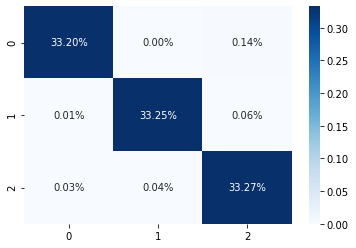

In [14]:
print('Val confusion matrix')
cf_matrix = confusion_matrix(y_val, val_preds)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues');

Test confusion matrix


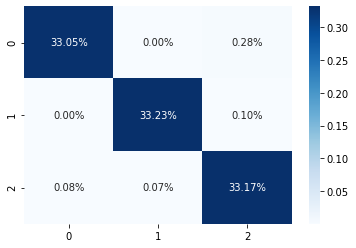

In [15]:
print('Test confusion matrix')
cf_matrix = confusion_matrix(y_test, test_preds)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues');

In [16]:
print(f"Val F1-micro : {f1_score(y_val, val_preds, average='micro')} \t F1-macro : {f1_score(y_val, val_preds, average='macro')}")
print(f"Test F1-micro : {f1_score(y_test, test_preds, average='micro')} \t F1-macro : {f1_score(y_test, test_preds, average='macro')}")

Val F1-micro : 0.9971801887319225 	 F1-macro : 0.9971815900146278
Test F1-micro : 0.9944876962435353 	 F1-macro : 0.994491157746522


## Logistic Regression model

In [17]:
%%time
# vanilla log-reg
linreg = LogisticRegression(max_iter=1000)
linreg.fit(X_train_vect, y_train)
val_preds = linreg.predict(X_val_vect)
test_preds = linreg.predict(X_test_vect)

CPU times: user 3min 39s, sys: 56.3 s, total: 4min 35s
Wall time: 54.2 s


Val confusion matrix


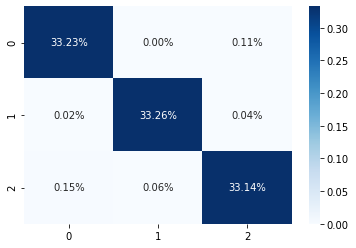

In [18]:
print('Val confusion matrix')
cf_matrix = confusion_matrix(y_val, val_preds)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues');

Test confusion matrix


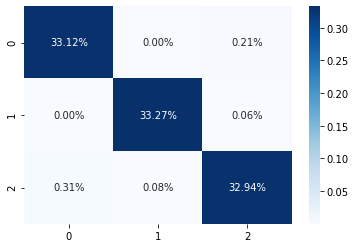

In [19]:
print('Test confusion matrix')
cf_matrix = confusion_matrix(y_test, test_preds)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues');

In [20]:
print(f"Val F1-micro : {f1_score(y_val, val_preds, average='micro')} \t F1-macro : {f1_score(y_val, val_preds, average='macro')}")
print(f"Test F1-micro : {f1_score(y_test, test_preds, average='micro')} \t F1-macro : {f1_score(y_test, test_preds, average='macro')}")

Val F1-micro : 0.9962588642581942 	 F1-macro : 0.9962589799510896
Test F1-micro : 0.9933787937349309 	 F1-macro : 0.9933770168934495


# Test

In [21]:
%%time
sample = ['Король']
sample_vect = vectorizer.transform(sample)
sample_preds = linreg.predict_proba(sample_vect)
print(sample_preds)
print(le.inverse_transform([np.argmax(sample_preds)]))

[[0.00052008 0.00000594 0.99947398]]
['Прізвище']
CPU times: user 1.11 ms, sys: 408 µs, total: 1.52 ms
Wall time: 1.08 ms


In [22]:
%%time
sample = ['Тарас']
sample_vect = vectorizer.transform(sample)
sample_preds = linreg.predict_proba(sample_vect)
print(sample_preds)
print(le.inverse_transform([np.argmax(sample_preds)]))

[[0.87869627 0.00009391 0.12120981]]
['Ім’я']
CPU times: user 1.05 ms, sys: 163 µs, total: 1.21 ms
Wall time: 1.04 ms


In [23]:
%%time
sample = ['Богдан']
sample_vect = vectorizer.transform(sample)
sample_preds = linreg.predict_proba(sample_vect)
print(sample_preds)
print(le.inverse_transform([np.argmax(sample_preds)]))

[[0.88229255 0.00005778 0.11764967]]
['Ім’я']
CPU times: user 1.21 ms, sys: 198 µs, total: 1.41 ms
Wall time: 1.25 ms


In [24]:
%%time
sample = ['Анатоліївна']
sample_vect = vectorizer.transform(sample)
sample_preds = linreg.predict_proba(sample_vect)
print(sample_preds)
print(le.inverse_transform([np.argmax(sample_preds)]))

[[0.000027   0.99997278 0.00000022]]
['По батькові']
CPU times: user 1.19 ms, sys: 811 µs, total: 2 ms
Wall time: 1.13 ms


In [25]:
%%time
sample = ['Солоха']
sample_vect = vectorizer.transform(sample)
sample_preds = linreg.predict_proba(sample_vect)
print(sample_preds)
print(le.inverse_transform([np.argmax(sample_preds)]))

[[0.001312   0.00000914 0.99867887]]
['Прізвище']
CPU times: user 1.55 ms, sys: 835 µs, total: 2.38 ms
Wall time: 1.6 ms


In [26]:
sample = 'ШЕВЧЕНКО МИКОЛА ІВАНОВИЧ'.split(' ')
sample_vect = vectorizer.transform(sample)
sample_preds = linreg.predict_proba(sample_vect)
print(le.inverse_transform(np.argmax(sample_preds, axis=1)))

['Прізвище' 'Ім’я' 'По батькові']


In [27]:
sample = 'БОЙКО ІВАН ВАСИЛЬОВИЧ'.split(' ')
sample_vect = vectorizer.transform(sample)
sample_preds = linreg.predict_proba(sample_vect)
print(le.inverse_transform(np.argmax(sample_preds, axis=1)))

['Прізвище' 'Ім’я' 'По батькові']


In [28]:
sample = 'БОЙКО ІВАН ВАСИЛЬОВИЧ'.split(' ')
sample = np.random.permutation(sample)
print(sample )
sample_vect = vectorizer.transform(sample)
sample_preds = linreg.predict_proba(sample_vect)
print(le.inverse_transform(np.argmax(sample_preds, axis=1)))

['БОЙКО' 'ВАСИЛЬОВИЧ' 'ІВАН']
['Прізвище' 'По батькові' 'Ім’я']


In [29]:
sample = ['Джон']
sample = np.random.permutation(sample)
print(sample )
sample_vect = vectorizer.transform(sample)
sample_preds = linreg.predict_proba(sample_vect)
print(le.inverse_transform(np.argmax(sample_preds, axis=1)))

['Джон']
['Прізвище']


In [30]:
sample = ['Вадома']
sample = np.random.permutation(sample)
print(sample )
sample_vect = vectorizer.transform(sample)
sample_preds = linreg.predict_proba(sample_vect)
print(le.inverse_transform(np.argmax(sample_preds, axis=1)))

['Вадома']
['Прізвище']


# Seq-2-Seq

In [25]:
import pandas as pd
import numpy as np

from tqdm.auto import tqdm
tqdm.pandas(desc='Progress')

In [26]:
data = pd.read_csv('data/final_dataset.csv')
data.shape

(119426, 3)

In [27]:
data.head()

,Прізвище,Ім’я,По батькові
0,Король,Тетяна,Олександрівна
1,Король,Сергій,Володимирович
2,Пащенко,Катерина,Михайлівна
3,Щоголева,Лідія,Степанівна
4,Солоха,Олег,Миколайович


In [28]:
def merge_rows(row):
    sample = f"({row['Прізвище']}, {['Прізвище']}) ({row['Ім’я']}, {['Ім’я']}) ({row['По батькові']}, {['По батькові']})"
    return sample

In [29]:
data['seq_text'] = data.progress_apply(lambda x: merge_rows(x), axis=1)

In [30]:
data['seq_text'].loc[1]

"(Король, ['Прізвище']) (Сергій, ['Ім’я']) (Володимирович, ['По батькові'])"